# Homework 7

Analyze `trace2` signals (note that these are signals different
from the `trace1` electrode we have been analysing up to now). First remove the
slow baseline fluctuations by subtracting a smoothed version of the signal, as
in the previous homework. Find the spikes by thresholding the signal: extract
the waveforms extending 29 timebins before and 30 timebins after the spike and
represent them as 60-dimensional vectors. By looking at these samples, do you
think signals on the `trace2` electrode come from an individual neuron (compare
with the analysis in Fig 26)? Compute the covariance matrix of samples and
do PCA. Project the samples onto the first two principal components and show
all spike samples as points on the plane (let’s denote the first projection by $y_1$
and second by $y_2$). Can you clearly define clusters of spikes in this plane? How
many spikes would you assign to each cluster? Plot the mean spike shape in each
cluster. How would you find a direction vector in the ($y_1$ , $y_2$) plane that best
separates spikes from first vs second cluster (in other words, can you find a linear
combination of $y_1$ and $y_2$ , i.e., $z = Ay_1 + By_2$ for some coefficients $A$ and $B$, such
that $z$ values for waveforms from the first cluster cleanly separate from $z$ values
for waveforms from the second cluster, e.g., by means of a threshold on $z$)? Do
you know how to visualize this direction vector (or the linear combination) as a
waveform in the original, 60-dimensional space?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trace2 = np.loadtxt('trace2.txt')

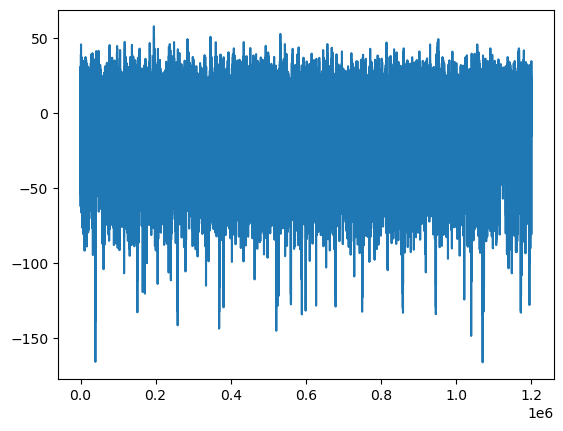

In [3]:
plt.plot(trace2)
plt.show()

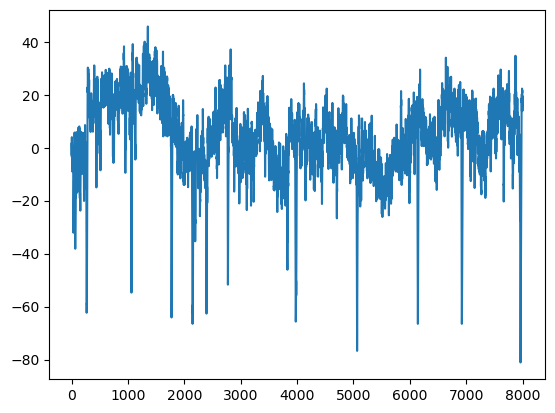

In [4]:
# Plot a subset of the trace
plt.plot(trace2[:8000])
plt.show()

## Subtract the baseline
Define a new time series, $\tilde{x}(t)$, such that each value of $\tilde{x}(t)$ corresponds to a moving average of the original time series, e.g.,
$$ 
\frac{1}{T} \sum_{t' = t-T/2+1}^{t+T/2} x(t')
$$

In [8]:
# Subtract the baseline

# First plot the baseline
T = 100 # time points for sliding window
baseline = np.zeros(len(trace2))



def compute_baseline(trace, T):
    baseline = np.zeros(len(trace))
    for t in range(len(trace)): # iterate over each trace element
        t_lower = int(t-T/2+1) # find the lower bound of the sliding window
        t_upper = int(t+T/2) # find the upper bound of the sliding window
        sum_ts = 0 # sum all the ts in the range
        counts = 0 # count the positive indices in the range
        for t_index in range(t_lower, t_upper+1): # iterate over each element of the window; if it's positive, sum it. Then divide by the total elements.
            if t_index>=0 and t_index<len(trace):
                sum_ts = sum_ts + trace[t_index]
                counts = counts + 1
        if counts>0:
            baseline[t] = sum_ts / counts
        
    return baseline

In [9]:
baseline = compute_baseline(trace2, T)

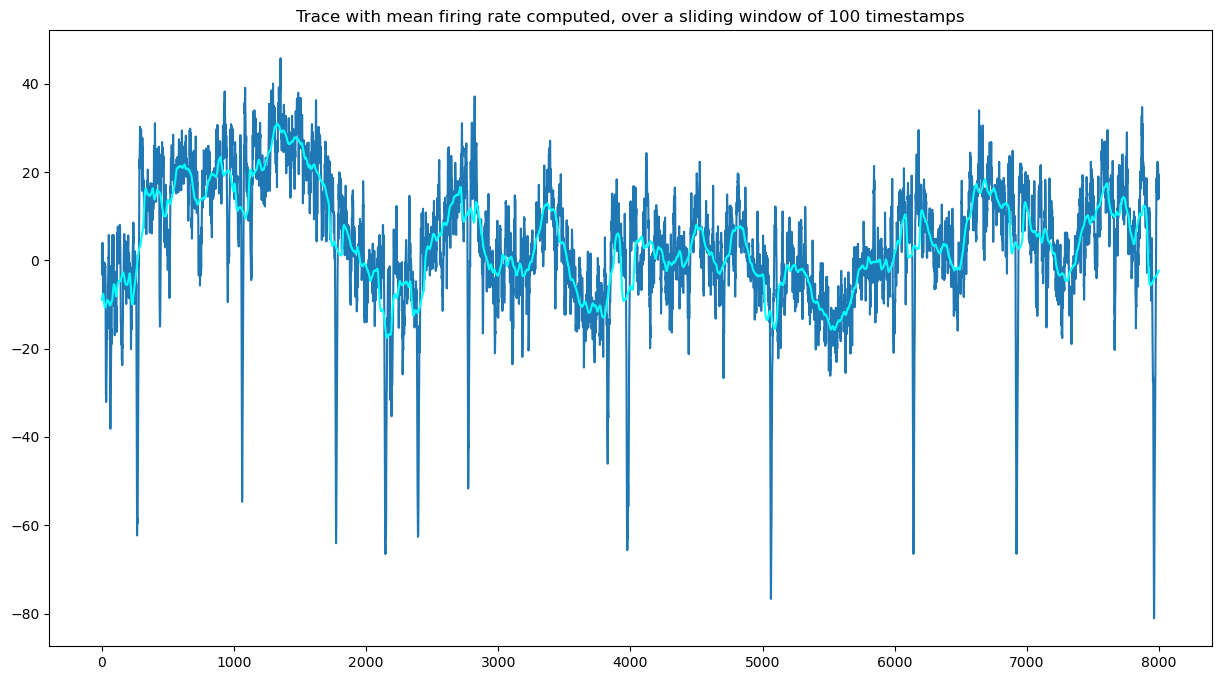

In [6]:
plt.figure(figsize=(15,8))
plt.title(f'Trace with mean firing rate computed, over a sliding window of {T} timestamps')
plt.plot(trace2[:8000])
plt.plot(baseline[:8000], color='cyan')
plt.show()

In [11]:
trace2_meansub  = trace2 - baseline

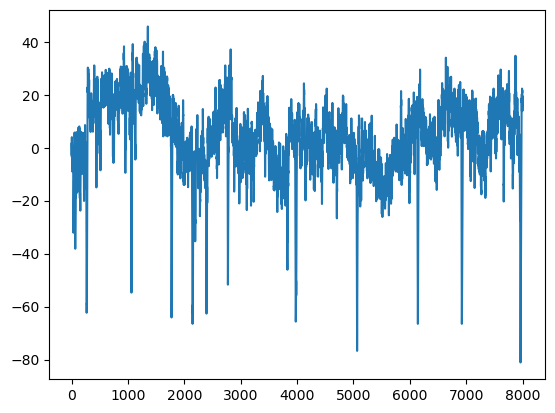

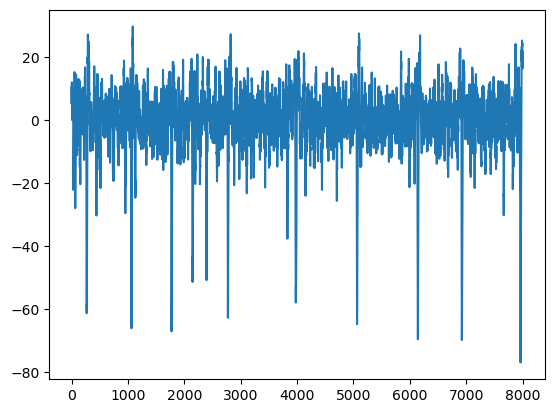

In [12]:
plt.plot(trace2[:8000])
plt.show()
plt.plot(trace2_meansub[:8000])
plt.show()

In [13]:
def getSpikes(data, threshold_mV):
    '''
    This function returns the number of spikes given a threshold. A spike is defined as a point during which the 
    signal crosses the threshold in a downward direction.
    '''
    # For each timestamp check if the voltage dips below threshold_mV and is decreasing (next timestamp is more negative than previous one).
    # Note on finding whether the voltage is decreasing: np.diff returns e[i+1]-e[i], so np.diff(data)<0 returns True if the subsequent element is more negative.
    # Because we can't know whether the function is decreasing after the last element, our spike detection only works up to the last element of the data.
    boolSpike = (data[:-1]<threshold_mV) & (np.diff(data)<0)
    spikeCount = sum(boolSpike)
    spikeIdx = np.where(boolSpike)[0]
    
    return spikeCount, spikeIdx

In [45]:
threshold = -50
spikeCount, spikeIdx = getSpikes(trace2, threshold)

(103,)


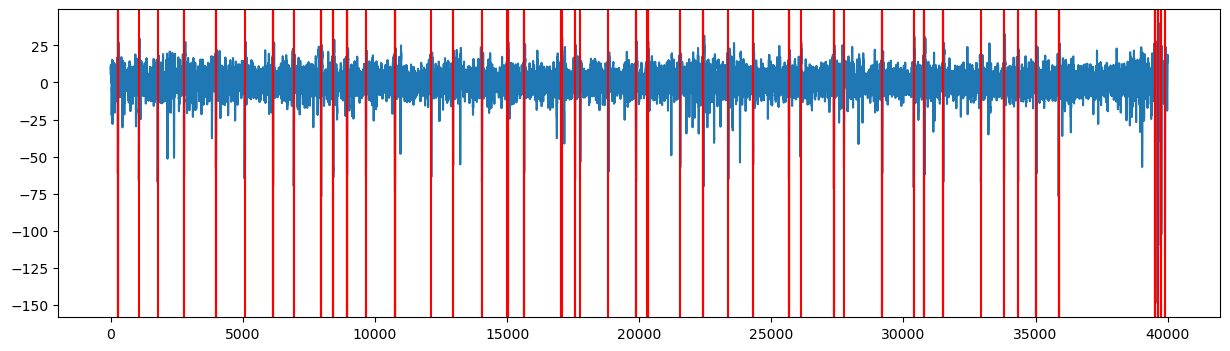

In [57]:
plt.figure(figsize=(15,4))

subset = trace2_meansub[:40_000]
plt.plot(subset)

_, spikeIdxSubset = getSpikes(subset, threshold)

print(spikeIdxSubset.shape)

for idx in range(len(spikeIdxSubset)):
    plt.axvline(x=spikeIdxSubset[idx], color='r')

plt.show()

In [188]:
print(trace2[spikeIdx[0]-29:spikeIdx[0]+30])
print(trace2[spikeIdx[0]-29])
print('spike index:',spikeIdx[0])

[  5.3142   3.8554   8.5444   4.8974  -0.7294  -4.5848  -7.9192  -5.4184
  -6.773   -9.899   -8.0234  -6.6688  -3.2302   2.084   -3.3344  -1.2504
   1.2504   0.1042  -1.563   -0.6252  -0.6252  -2.1882  -7.1898  -5.21
  -5.9394 -14.3796 -18.6518 -27.613  -41.159  -51.8916 -62.3116 -58.4562
 -59.7066 -58.873  -59.0814 -52.3084 -47.3068 -39.4918 -31.0516 -24.487
 -23.0282 -17.714  -10.941   -1.9798  -1.3546   5.5226  10.941   18.1308
  22.8198  20.84    25.4248  25.529   30.218   28.3424  27.092   26.3626
  26.4668  27.9256  25.529 ]
5.3142
spike index: 265


In [193]:
def extract_waveforms(trace, spikeIdx):
    """
    This function extracts the voltage 29 timestamps before the spike and 30 timestamps after and stores them in a vector.
    Input: raw trace, spike indices.
    Output: waveforms, a vector of length spikeIdx*60
    """
    # create a vector of length spikeIdx*60
    waveforms = np.zeros((len(spikeIdx), 60))
    # iterate over each spike and find the 29 timestamps preceding and 30 timestamps following
    for spike in range(len(spikeIdx)):
        spike_index = spikeIdx[spike] # the timestamp of the spike; for voltage val call trace[spike_index]
        
        # iterate over waveform timestamps (timestamps around the spike):
        for timestamp in range(60):
            corrected_timestamp = timestamp - 29 # the timestamp relative to the spike; ranges from -29 to 30 instead of 0 to 60
            waveform_index = spike_index+corrected_timestamp # the index on the trace of the waveform timestamp
            waveform_voltage = trace[waveform_index] # the value of the voltage at the waveform timestamp
            waveforms[spike, timestamp] = waveform_voltage # store in a vector
            
    return waveforms

In [194]:
waveforms = extract_waveforms(trace2, spikeIdx)

In [195]:
print(waveforms[0])

[  5.3142   3.8554   8.5444   4.8974  -0.7294  -4.5848  -7.9192  -5.4184
  -6.773   -9.899   -8.0234  -6.6688  -3.2302   2.084   -3.3344  -1.2504
   1.2504   0.1042  -1.563   -0.6252  -0.6252  -2.1882  -7.1898  -5.21
  -5.9394 -14.3796 -18.6518 -27.613  -41.159  -51.8916 -62.3116 -58.4562
 -59.7066 -58.873  -59.0814 -52.3084 -47.3068 -39.4918 -31.0516 -24.487
 -23.0282 -17.714  -10.941   -1.9798  -1.3546   5.5226  10.941   18.1308
  22.8198  20.84    25.4248  25.529   30.218   28.3424  27.092   26.3626
  26.4668  27.9256  25.529   28.655 ]


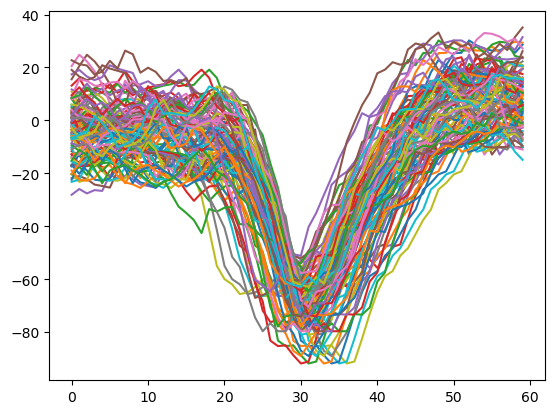

In [209]:
for waveform in range(100):
    plt.plot(waveforms[waveform,:])

plt.show()